<a href="https://www.kaggle.com/code/rputtam/classification-using-spark-mllib?scriptVersionId=223660425" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/loan-status-prediction/loan_data.csv


In [ ]:
#### test changes sync

## The objective of this notebook is to predict loan approval status of members.
#### **Prediction Algorithm**: Logistic Regression
#### **Library**: spark MLib

The notebook adheres to the following steps.
1. Installing and importing packages
2. Load the data
3. Data Exploration (EDA)
4. Data Splitting
5. Data Preprocessing
6. Build Model
7. Model Summary - coefficients and pValues
8. Add a wrapper transformer
9. Save the model artificat
10. Reuse the model

## 1. Install and import necessary packages

In [3]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 4.7 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.4-py2.py3-none-any.whl size=317849767 sha256=85d161533cc486e65c66cdecf643f13fb875daf9891ed795ebd0b2d872b34c7e
  Stored in directory: /root/.cache/pip/wheels/d9/1c/98/31e395a42d1735d18d42124971ecbbade844b50bb9845b6f4a
Successfully built pyspark
Note: you may need to restart the kernel to use updated packages.


In [4]:
#Creating spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('classification with MLlib').getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/02/20 23:50:56 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
# Importing packages
from pyspark.sql.types import *
import pyspark.sql.functions as F
import seaborn as sns
import matplotlib.pyplot as plt

## 2. Data loading

In [6]:
df=spark.read.csv('/kaggle/input/loan-status-prediction/loan_data.csv',inferSchema=True,header=True)

In [6]:
df.describe()

DataFrame[summary: string, Loan_ID: string, Gender: string, Married: string, Dependents: string, Education: string, Self_Employed: string, ApplicantIncome: string, CoapplicantIncome: string, LoanAmount: string, Loan_Amount_Term: string, Credit_History: string, Property_Area: string, Loan_Status: string]

 ## 3. Data Exploration (Exploratory Data Analysis)

1. Dataframe size
2. Get the field names and their data types, and, number of numeric and categorical features
3. A glimpse of data
4. Missing values count
5. Target variable distribution
6. Continuous variables distribution - normality check and boxplot for outliers
7. Categorical variables distribution
8. Predictors relation with target

#### 1. Dataframe size

In [7]:
print('Records:',df.count(),'\nColumns:', len(df.columns))

Records: 381 
Columns: 13


In [8]:
df.printSchema()

root
 |-- Loan_ID: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Married: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- Education: string (nullable = true)
 |-- Self_Employed: string (nullable = true)
 |-- ApplicantIncome: integer (nullable = true)
 |-- CoapplicantIncome: double (nullable = true)
 |-- LoanAmount: double (nullable = true)
 |-- Loan_Amount_Term: double (nullable = true)
 |-- Credit_History: double (nullable = true)
 |-- Property_Area: string (nullable = true)
 |-- Loan_Status: string (nullable = true)



#### 2. Get the field names and their data types, and, number of numeric and categorical features

In [9]:
numeric_data_types=['IntegerType','DoubleType','FloatType','LongType']
string_data_types=['StringType']

cat_cols=0
num_cols=0
other_cols=0

num_cols_list=[]
cat_cols_list=[]
oth_cols_list=[]

for field in df.schema.fields:
    if str(field.dataType)[:-2] in string_data_types:
        cat_cols_list.append(field.name)
        cat_cols+=1
    elif str(field.dataType)[:-2] in numeric_data_types:
        num_cols_list.append(field.name)
        num_cols+=1
    else:
        oth_cols_list.append(field.name)
        other_cols+1
print('Numeric cols:', num_cols,num_cols_list,'\nCategorical Cols:', cat_cols, cat_cols_list,'\nOther Cols:',other_cols,oth_cols_list)  

Numeric cols: 5 ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History'] 
Categorical Cols: 8 ['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status'] 
Other Cols: 0 []


In [ ]:
#df.show(5)

#### 3. Data Glimpse

In [10]:
df.toPandas().head()
# numeric variables such as income, loan amount, term are considered as strings, but should be converted to numeric data types which is done in data preprocessing step

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
1,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
2,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
3,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
4,LP001013,Male,Yes,0,Not Graduate,No,2333,1516.0,95.0,360.0,1.0,Urban,Y


#### 4. Missing values Summary

In [11]:
missing_values_dict={}
for c in df.columns:
    missing_values_dict[c]=df.agg(F.count(F.when(F.isnan(c) | F.col(c).isNull(),c))).collect()[0][0]
    
missing_values_dict

{'Loan_ID': 0,
 'Gender': 5,
 'Married': 0,
 'Dependents': 8,
 'Education': 0,
 'Self_Employed': 21,
 'ApplicantIncome': 0,
 'CoapplicantIncome': 0,
 'LoanAmount': 0,
 'Loan_Amount_Term': 11,
 'Credit_History': 30,
 'Property_Area': 0,
 'Loan_Status': 0}

#### 5. Target class distribution

In [12]:
# Creating target variable
df = df.withColumn('target', F.when(F.col('Loan_Status') == 'Y',1).otherwise(0))
print(df.select('target').dtypes)
df.agg(F.mean('target')).collect()[0][0]

[('target', 'int')]


0.7112860892388452

In [13]:
total_count=df.count()
# Get the target class distribution
df_prop = df.groupBy(['Loan_Status'])\
.agg(F.count('Loan_ID').alias('appl_ct'))\
.withColumn('prop',F.round(F.col('appl_ct')/total_count*100,2))\

df_prop.show()

+-----------+-------+-----+
|Loan_Status|appl_ct| prop|
+-----------+-------+-----+
|          Y|    271|71.13|
|          N|    110|28.87|
+-----------+-------+-----+



In [14]:
df_target_stats=df_prop.toPandas()
df_target_stats.head()

,Loan_Status,appl_ct,prop
0,Y,271,71.13
1,N,110,28.87


Text(0.5, 1.0, 'Distribution of Loan Status')

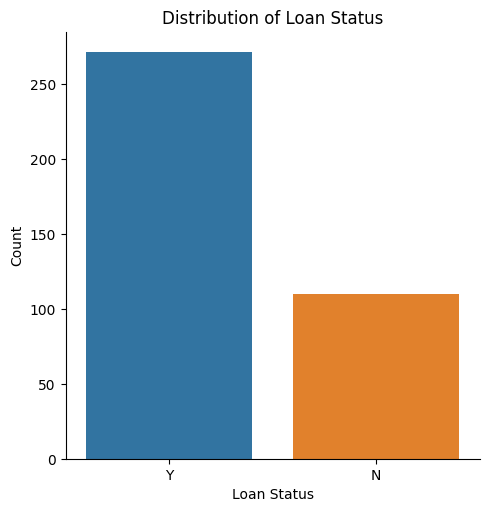

In [15]:
sns.catplot(data=df_target_stats,x='Loan_Status',y='appl_ct',kind='bar')

plt.xlabel('Loan Status')
plt.ylabel('Count')
plt.title('Distribution of Loan Status')

### Summary Statistics

In [16]:
df.describe().toPandas().head()

25/02/20 04:51:09 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,summary,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,target
0,count,381,376,381,373,381,360,381,381,381,370,351,381,381,381
1,mean,None,None,None,0.4927536231884058,None,None,3579.845144356955,1277.2753805476116,104.98687664041995,340.86486486486484,0.8376068376068376,None,None,0.7112860892388452
2,stddev,None,None,None,0.7705175775917269,None,None,1419.8138182832997,2340.8181138037494,28.35846362028739,68.54925717464621,0.369337591385248,None,None,0.4537605147868925
3,min,LP001003,Female,No,0,Graduate,No,150,0.0,9.0,12.0,0.0,Rural,N,0
4,max,LP002990,Male,Yes,3+,Not Graduate,Yes,9703,33837.0,150.0,480.0,1.0,Urban,Y,1


In [17]:
df.toPandas().describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,target
count,381.000000,381.000000,381.000000,370.000000,351.000000,381.000000
mean,3579.845144,1277.275381,104.986877,340.864865,0.837607,0.711286
std,1419.813818,2340.818114,28.358464,68.549257,0.369338,0.453761
min,150.000000,0.000000,9.000000,12.000000,0.000000,0.000000
25%,2600.000000,0.000000,90.000000,360.000000,1.000000,0.000000
50%,3333.000000,983.000000,110.000000,360.000000,1.000000,1.000000
75%,4288.000000,2016.000000,127.000000,360.000000,1.000000,1.000000
max,9703.000000,33837.000000,150.000000,480.000000,1.000000,1.000000


In [18]:
df.toPandas().describe(include='object')

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Property_Area,Loan_Status
count,381,376,381,373,381,360,381,381
unique,381,2,2,4,2,2,3,2
top,LP001003,Male,Yes,0,Graduate,No,Semiurban,Y
freq,1,291,228,234,278,325,149,271


In [141]:
df.toPandas()['Dependents'].unique()

array(['1', '0', '2', '3+', None], dtype=object)

In [19]:
string_fields = [col for col,dtype in df.dtypes if dtype =='string']
string_fields.remove('Loan_ID')
for string_field in string_fields:
    df.select(string_field).distinct().show(5)

+------+
|Gender|
+------+
|Female|
|  Male|
|  NULL|
+------+

+-------+
|Married|
+-------+
|     No|
|    Yes|
+-------+

+----------+
|Dependents|
+----------+
|         0|
|         1|
|        3+|
|         2|
|      NULL|
+----------+

+------------+
|   Education|
+------------+
|Not Graduate|
|    Graduate|
+------------+

+-------------+
|Self_Employed|
+-------------+
|           No|
|          Yes|
|         NULL|
+-------------+

+-------------+
|Property_Area|
+-------------+
|        Urban|
|    Semiurban|
|        Rural|
+-------------+

+-----------+
|Loan_Status|
+-----------+
|          Y|
|          N|
+-----------+



In [20]:
df_p=df.toPandas()

In [21]:
# Get the levels of caterogical variables
for i in string_fields:
    print(i,(df_p[i].nunique(),df_p[i].unique()))
#df_p.Gender.value_counts()

Gender (2, array(['Male', 'Female', None], dtype=object))
Married (2, array(['Yes', 'No'], dtype=object))
Dependents (4, array(['1', '0', '2', '3+', None], dtype=object))
Education (2, array(['Graduate', 'Not Graduate'], dtype=object))
Self_Employed (2, array(['No', 'Yes', None], dtype=object))
Property_Area (3, array(['Rural', 'Urban', 'Semiurban'], dtype=object))
Loan_Status (2, array(['N', 'Y'], dtype=object))


#### 6. Continuous variables distribution - normality check and boxplot for outliers
Data distribution plots of continuous variables

In [22]:
num_cols_list

['ApplicantIncome',
 'CoapplicantIncome',
 'LoanAmount',
 'Loan_Amount_Term',
 'Credit_History']

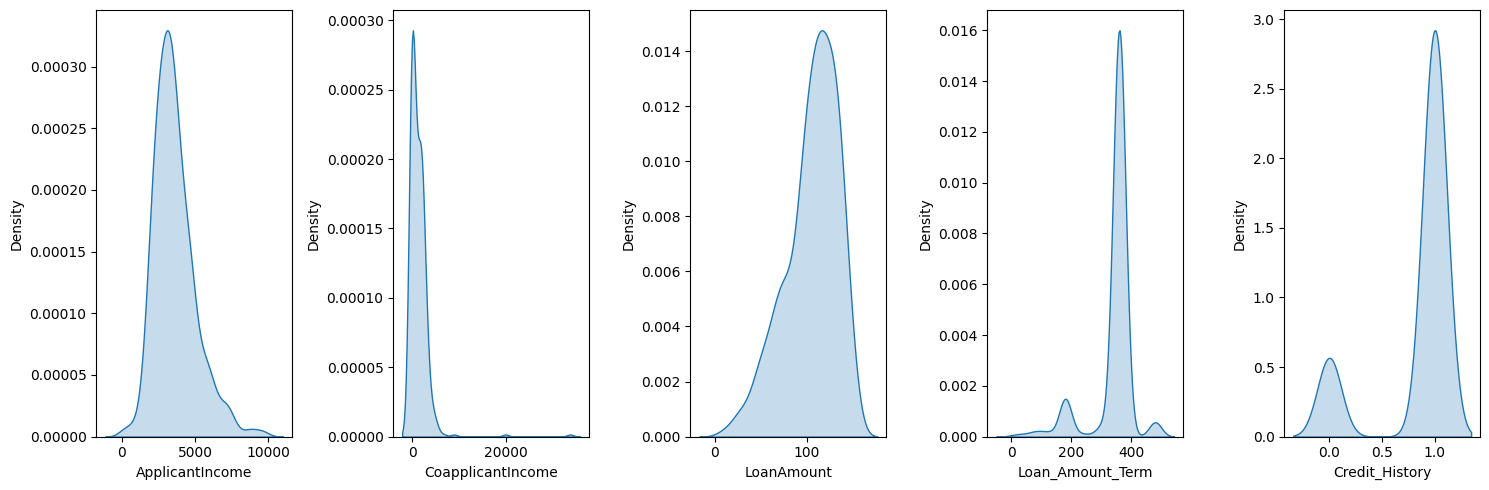

In [23]:
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

fig,axs = plt.subplots(1,5,figsize=(15,5))
for i,col in enumerate(num_cols_list):
    sns.kdeplot(data=df_p[col],ax=axs[i],fill=True)
plt.tight_layout()
plt.show()

<Axes: >

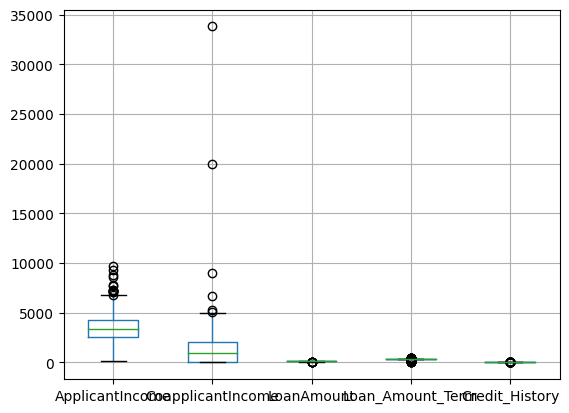

In [24]:
#Nuemric variables box plot to cehck for outliers
df_p.boxplot(column=num_cols_list)

<Axes: >

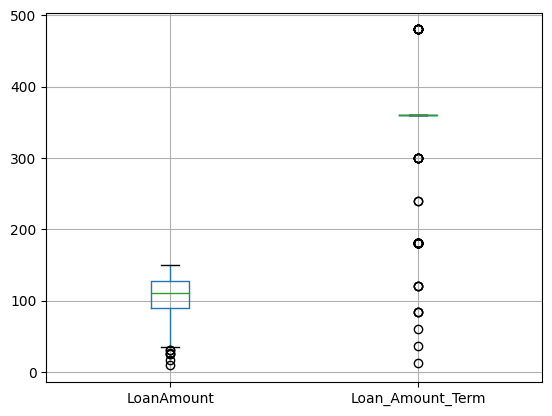

In [25]:
df_p.boxplot(column=['LoanAmount','Loan_Amount_Term'])
# It can be seen from the below plot that the range of these numeric variables is wide and there seem to be outliers for loan_amount_term

<Axes: >

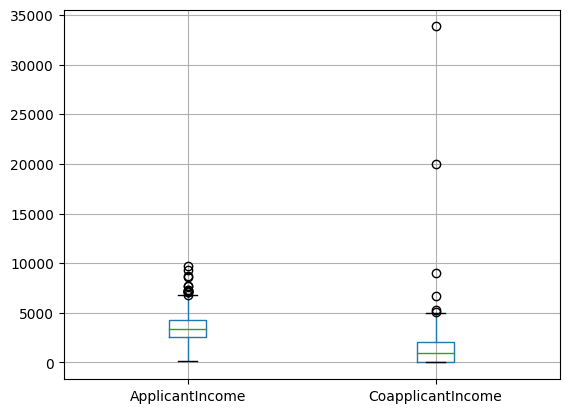

In [26]:
df_p.boxplot(column=['ApplicantIncome','CoapplicantIncome'])
# There seem to be instances where coapplicant income is higher than applicant income

#### 7. Categorical variables distribution plots

In [28]:
cat_cols_list

['Loan_ID',
 'Gender',
 'Married',
 'Dependents',
 'Education',
 'Self_Employed',
 'Property_Area',
 'Loan_Status']

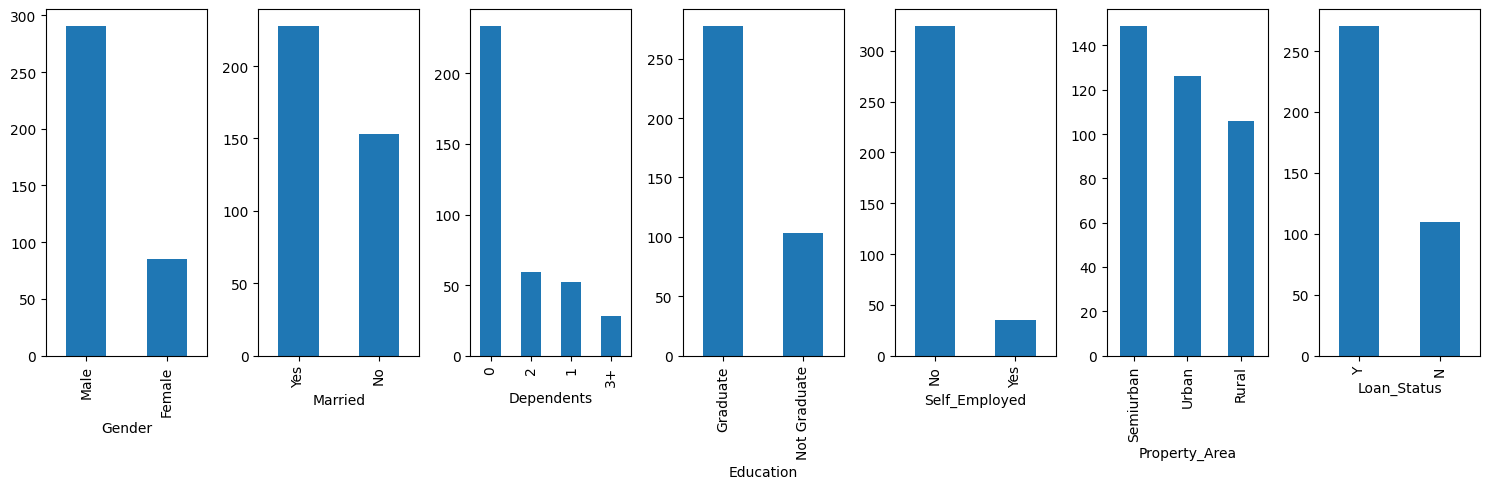

In [29]:
# Catgeorical variables counts plot
fig,axes=plt.subplots(nrows=1,ncols=len(cat_cols_list)-1,figsize=(15,5))
for i,col in enumerate(cat_cols_list[1:]):
    cat_counts =df_p[col].value_counts()
    cat_counts.plot(kind='bar',ax=axes[i])

plt.tight_layout()
plt.show()

#### 8. Predictors relationship with target

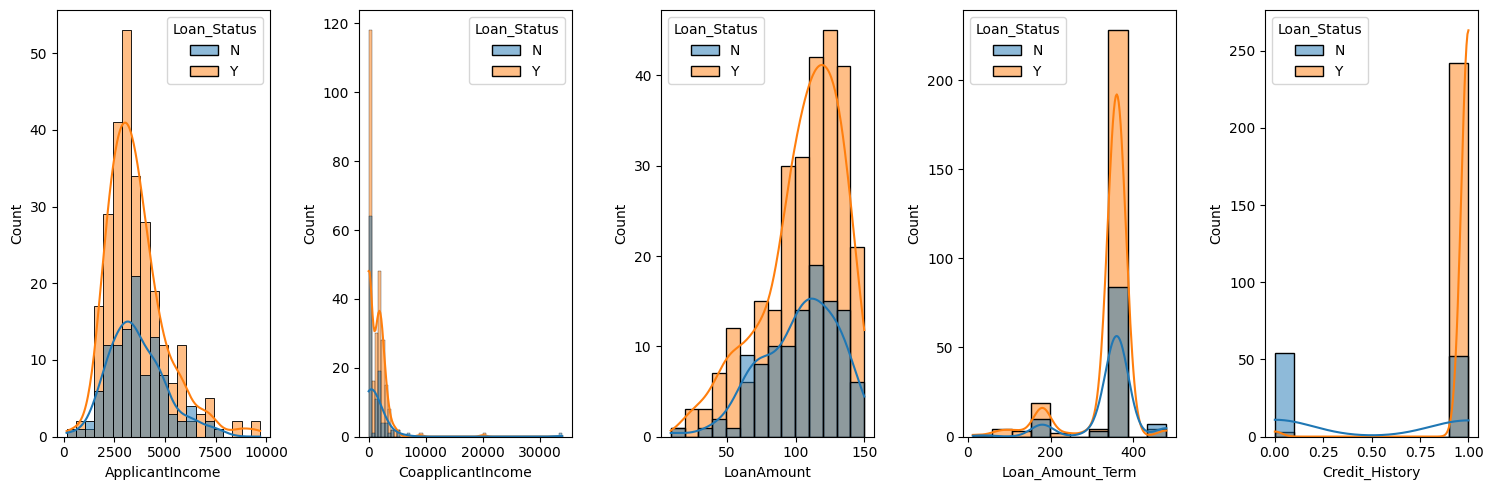

In [30]:
#Distributions 
fig,axes = plt.subplots(nrows=1,ncols=len(num_cols_list),figsize=(15,5))
for i,col in enumerate(num_cols_list):
    sns.histplot(data=df_p,ax=axes[i],x=col,kde=True,hue='Loan_Status')
plt.tight_layout()
plt.show()

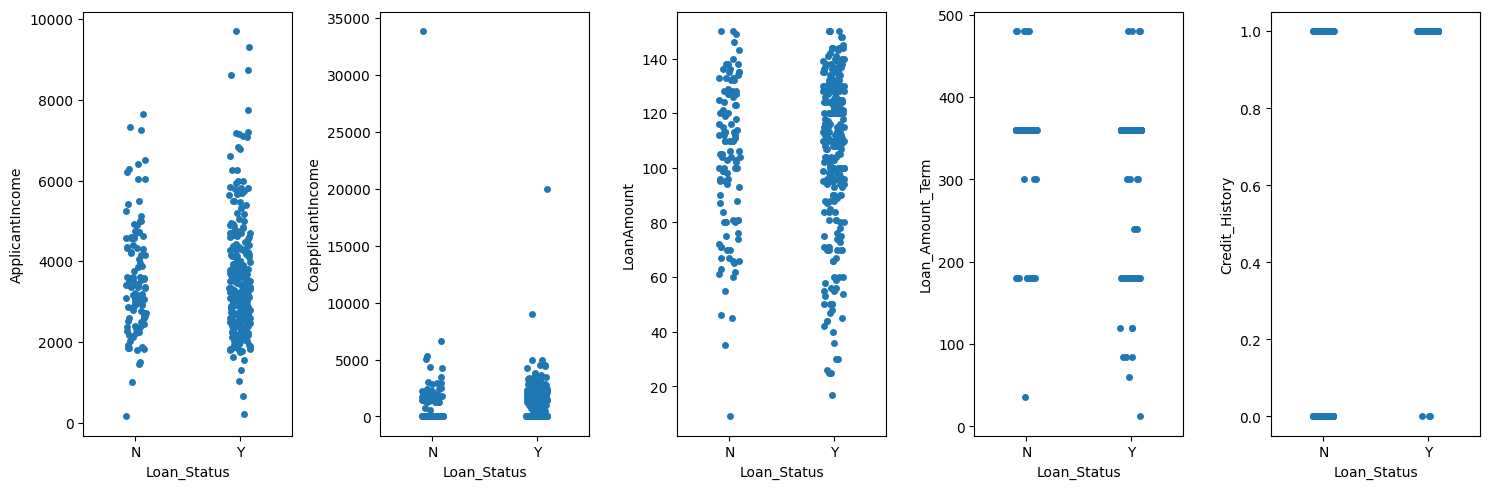

In [31]:
fig,axes =plt.subplots(nrows=1,ncols=len(num_cols_list),figsize=(15,5))
for i,col in enumerate(num_cols_list):
    sns.stripplot(df_p,x='Loan_Status',y=col,ax=axes[i])
plt.tight_layout()
plt.show()

In [ ]:
#df_p.Loan_Status=df_p.Loan_Status.map(dict(Y=1,N=0))

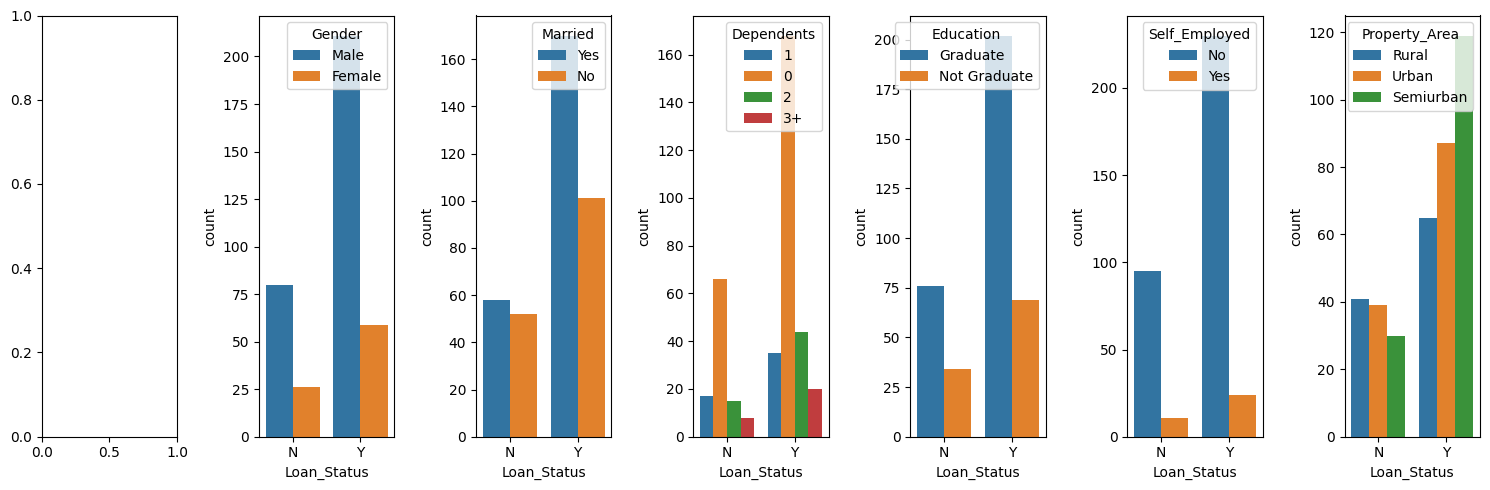

In [32]:
fig,axes = plt.subplots(nrows=1,ncols=len(cat_cols_list)-1,figsize=(15,5))
for i,col in enumerate(cat_cols_list):
    if col not in ['Loan_Status','Loan_ID']:
        sns.countplot(df_p,ax=axes[i],x='Loan_Status',hue=col)
plt.tight_layout()
plt.show()

## 4. Data splitting

In [16]:
df.agg(F.collect_set("Loan_Status")).collect()[0][0]

['N', 'Y']

In [17]:
df_0 = df.filter(df.Loan_Status == 'N')
df_1 = df.filter(df.Loan_Status == 'Y')

In [19]:
train_0, test_0 = df_0.randomSplit([0.8, 0.2], seed=42)
train_1, test_1 = df_1.randomSplit([0.8, 0.2], seed=42)

In [20]:
train_df = train_0.union(train_1)
test_df = test_0.union(test_1)

In [21]:
print("Original class distribution:")
total_count=df.count()
# Get the target class distribution
df_prop = df.groupBy(['Loan_Status'])\
.agg(F.count('Loan_ID').alias('appl_ct'))\
.withColumn('prop',F.round(F.col('appl_ct')/total_count*100,2))\

df_prop.show()

print("Train dataset distributions")
train_df_count=train_df.count()
# Get the target class distribution
train_df_prop = train_df.groupBy(['Loan_Status'])\
.agg(F.count('Loan_ID').alias('appl_ct'))\
.withColumn('prop',F.round(F.col('appl_ct')/train_df_count*100,2))\

train_df_prop.show()

print("Test dataset distributions")
test_df_count=test_df.count()
# Get the target class distribution
test_df_prop = test_df.groupBy(['Loan_Status'])\
.agg(F.count('Loan_ID').alias('appl_ct'))\
.withColumn('prop',F.round(F.col('appl_ct')/test_df_count*100,2))\

test_df_prop.show()

Original class distribution:
+-----------+-------+-----+
|Loan_Status|appl_ct| prop|
+-----------+-------+-----+
|          Y|    271|71.13|
|          N|    110|28.87|
+-----------+-------+-----+

Train dataset distributions
+-----------+-------+-----+
|Loan_Status|appl_ct| prop|
+-----------+-------+-----+
|          N|     92|28.66|
|          Y|    229|71.34|
+-----------+-------+-----+

Test dataset distributions
+-----------+-------+----+
|Loan_Status|appl_ct|prop|
+-----------+-------+----+
|          N|     18|30.0|
|          Y|     42|70.0|
+-----------+-------+----+



## 5. Data Preprocessing

The objective is to have a pipeline with the preprocessing and model building steps that can be used on any similar dataset

### Steps

1. Convert all numeric to double and categorical to string
2. Impute missing values - numerical with median and categorical with 'unknown'
3. String indexer - To make give numeric labels to categorical variables
4. One hot encoding - Create individual fields for each label of categorical column with more than two levels
5. Vector assembler to get an array of predictors

## Set up the preprocessing pipeline

In [44]:
train_df.printSchema()

root
 |-- Loan_ID: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Married: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- Education: string (nullable = true)
 |-- Self_Employed: string (nullable = true)
 |-- ApplicantIncome: integer (nullable = true)
 |-- CoapplicantIncome: double (nullable = true)
 |-- LoanAmount: double (nullable = true)
 |-- Loan_Amount_Term: double (nullable = true)
 |-- Credit_History: double (nullable = true)
 |-- Property_Area: string (nullable = true)
 |-- Loan_Status: string (nullable = true)
 |-- target: integer (nullable = false)



In [22]:
import json
from pyspark.ml import Estimator, Transformer, Pipeline
from pyspark.ml.param import Param, Params, TypeConverters
from pyspark.ml.param.shared import HasInputCols, HasOutputCols
from pyspark.ml.util import DefaultParamsReadable, DefaultParamsWritable
from pyspark.sql.functions import col, median, when,lit
from pyspark.sql.types import DoubleType, StringType
from pyspark.ml.feature import Imputer, OneHotEncoder, VectorAssembler, StringIndexer

#### Custom Estimator and Transformer to change datatypes of specified columns into numeric and string datatypes


* Estimator: This is the main class that DataTypeConverter inherits from, providing the basic structure and functionality of an estimator in the PySpark ML pipeline.
* DefaultParamsReadable: This mixin class provides functionality for reading parameters from a saved model. It allows the DataTypeConverter to be loaded from disk after being saved as part of a pipeline.
* DefaultParamsWritable: This mixin class provides functionality for writing parameters when saving a model. It allows the DataTypeConverter to be saved to disk as part of a pipeline.
* Param: Defines parameters for ML components, specifying name, description, and type; ensures type safety and provides documentation. _setDefault() & Getters/Setters: Set default parameter values and provide controlled access, ensuring seamless integration with PySpark's ML Pipelines.


#### 1. DataTypeConverter
Convert all numeric to double and categorical to string

In [23]:
features = ['ApplicantIncome','CoapplicantIncome','LoanAmount','Loan_Amount_Term', 
            'Gender', 'Married','Dependents','Education',
            'Self_Employed','Credit_History','Property_Area'] #without target var
num_cols = ['ApplicantIncome','CoapplicantIncome','LoanAmount','Loan_Amount_Term']
cat_cols=['Gender', 'Married','Dependents','Education','Self_Employed','Credit_History',
        'Property_Area']
target_var = 'Loan_Status'

In [24]:
class DataTypeConverter(Estimator, DefaultParamsReadable, DefaultParamsWritable):
    
    numericCols = Param(Params._dummy(), "numericCols", "Columns to be converted to DoubleType",
                        typeConverter=TypeConverters.toListString)
    categoricalCols = Param(Params._dummy(), "categoricalCols", "Columns to be converted to StringType",
                            typeConverter=TypeConverters.toListString)

    def __init__(self, numericCols=None, categoricalCols=None):
        super(DataTypeConverter, self).__init__()
        self._setDefault(numericCols=[], categoricalCols=[])
        self.setNumericCols(numericCols)
        self.setCategoricalCols(categoricalCols)

    def setNumericCols(self, value):
        return self._set(numericCols=value)

    def getNumericCols(self):
        return self.getOrDefault(self.numericCols)

    def setCategoricalCols(self, value):
        return self._set(categoricalCols=value)

    def getCategoricalCols(self):
        return self.getOrDefault(self.categoricalCols)
        
    def _fit(self, dataset):
        return DataTypeConverterModel(self.getNumericCols(), self.getCategoricalCols())

class DataTypeConverterModel(Transformer, DefaultParamsReadable, DefaultParamsWritable):
    numericCols = Param(Params._dummy(), "numericCols", "Columns to be converted to DoubleType",
                        typeConverter=TypeConverters.toListString)
    categoricalCols = Param(Params._dummy(), "categoricalCols", "Columns to be converted to StringType",
                            typeConverter=TypeConverters.toListString)
    
    def __init__(self, numericCols=None, categoricalCols=None):
        super(DataTypeConverterModel, self).__init__()
        self._setDefault(numericCols=[], categoricalCols=[])
        self.setNumericCols(numericCols)
        self.setCategoricalCols(categoricalCols)

    def setNumericCols(self, value):
        return self._set(numericCols=value)

    def getNumericCols(self):
        return self.getOrDefault(self.numericCols)

    def setCategoricalCols(self, value):
        return self._set(categoricalCols=value)

    def getCategoricalCols(self):
        return self.getOrDefault(self.categoricalCols)
        
    def _transform(self,dataset):
        for col_name in self.getNumericCols():
            dataset = dataset.withColumn(col_name,col(col_name).cast(DoubleType()))
        for col_name in self.getCategoricalCols():
            dataset = dataset.withColumn(col_name,col(col_name).cast(StringType()))
        return dataset

In [25]:
data_type_converter = DataTypeConverter(numericCols=num_cols, 
                                        categoricalCols=cat_cols)

#### 2. CustomImputer
Impute missing values - numerical with median and categorical with 'unknown'

In [26]:
class CustomImputer(Estimator, HasInputCols, HasOutputCols,
                    DefaultParamsReadable, DefaultParamsWritable):
    
    inputCols = Param(Params._dummy(), "inputCols", "Columns to be checked and imputed",
                        typeConverter=TypeConverters.toListString)

        
    def __init__(self, inputCols=None):
        super(CustomImputer, self).__init__()
        self._setDefault(inputCols=[])
        self.setInputCols(inputCols)

    def setInputCols(self, value):
        return self._set(inputCols=value)

    def getInputCols(self):
        return self.getOrDefault(self.inputCols)
        
    def _fit(self, dataset):
        "get numeric cols from inputcols list and get the fill value as median aka numericaimputer"
        "get categorical cols from inputcols list and get the fill value aka categoricalimputer"
        numericCols = [field.name for field in dataset.schema.fields if isinstance(field.dataType, DoubleType)]
        categoricalCols = [field.name for field in dataset.schema.fields if isinstance(field.dataType, StringType)]
        # Initialize an empty dictionary to store the medians
        median_values = {}

        # Iterate through the numeric columns and calculate median
        for column in numericCols:
        # Calculate the median
            median_value = df.select(median(col(column))).collect()[0][0]
    
        # Store the median in the dictionary
            median_values[column] = median_value
        return CustomImputerModel(inputCols=self.getInputCols(), 
                                  numericCols=numericCols,
                                  categoricalCols=categoricalCols,
                                  numericFill=median_values,
                                 categoricalFill='unknown')

class CustomImputerModel(Transformer, HasInputCols, HasOutputCols):
    inputCols = Param(Params._dummy(),"inputCols","InputColumns to impute",
                     typeConverter= TypeConverters.toListString)
    numericCols = Param(Params._dummy(), "numericCols", "Numeric columns to impute",
                        typeConverter=TypeConverters.toListString)
    categoricalCols = Param(Params._dummy(), "categoricalCols", "Categorical columns to impute",
                            typeConverter=TypeConverters.toListString)
    numericFill = Param(Params._dummy(), "numericFill", "JSON string of numeric fill values")
    categoricalFill = Param(Params._dummy(), "categoricalFill", "Fill value for categorical columns",
                            typeConverter=TypeConverters.toString)
    
    def __init__(self, inputCols=None, numericCols=None, categoricalCols=None, numericFill=None, categoricalFill=None):
        super(CustomImputerModel, self).__init__()
        self._setDefault(inputCols=[],numericCols=[], categoricalCols=[], numericFill={}, categoricalFill="unknown")
        self.setInputCols(inputCols)
        self.setNumericCols(numericCols)
        self.setCategoricalCols(categoricalCols)
        self.setNumericFill(numericFill)
        self.setCategoricalFill(categoricalFill)

    def setInputCols(self,value):
        return self._set(inputCols=value)

    def setNumericCols(self, value):
        return self._set(numericCols=value)

    def getNumericCols(self):
        return self.getOrDefault(self.numericCols)

    def setCategoricalCols(self, value):
        return self._set(categoricalCols=value)

    def getCategoricalCols(self):
        return self.getOrDefault(self.categoricalCols)

    def setNumericFill(self, value):
        return self._set(numericFill=json.dumps(value))

    def getNumericFill(self):
        return json.loads(self.getOrDefault(self.numericFill))

    def setCategoricalFill(self, value):
        return self._set(categoricalFill=value)

    def getCategoricalFill(self):
        return self.getOrDefault(self.categoricalFill)

   
    def _transform(self, dataset):
        
        numericFill = self.getNumericFill()
        for column in self.getNumericCols():
            
            if column in self.getInputCols():
                dataset = dataset.withColumn(column, when(col(column).isNull(), lit(numericFill[column])).otherwise(col(column)))
        
        # Impute categorical columns
        for column in self.getCategoricalCols():
            if column in self.getInputCols():
                dataset = dataset.withColumn(column, when(col(column).isNull(), lit(self.getCategoricalFill())).otherwise(col(column)))
        
        return dataset

In [27]:
custom_imputer = CustomImputer(inputCols=features)

#### 3. String indexer 
To make give numeric labels to categorical variables

In [124]:
string_indexer = StringIndexer(inputCols=cat_cols+[target_var], 
                               outputCols=[f"{col}_indexed" for col in cat_cols + [target_var]],
                              handleInvalid = 'keep')

#### 4. OneHotEncoder
Create individual fields for each label of categorical column with more than two levels

In [153]:
one_hot_encoder = OneHotEncoder(inputCols=[f"{col}_indexed" for col in cat_cols], 
                       outputCols=[f"{col}_encoded" for col in cat_cols], dropLast = True)

#### 5. Vector assembler 
To get an array of predictors

In [143]:
vector_assembler = VectorAssembler(inputCols=[f"{col}_encoded" for col in cat_cols] + num_cols, outputCol="features")

#### Set up preprocessing steps in a pipeline

In [154]:
pipeline=Pipeline(stages=[data_type_converter,custom_imputer,string_indexer,one_hot_encoder,vector_assembler])

In [155]:
preprocessed_pipeline=pipeline.fit(df)

In [156]:
preprocessed_df=preprocessed_pipeline.transform(df)

In [157]:
preprocessed_df.toPandas().head(5)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,...,Property_Area_indexed,Loan_Status_indexed,Gender_encoded,Married_encoded,Dependents_encoded,Education_encoded,Self_Employed_encoded,Credit_History_encoded,Property_Area_encoded,features
0,LP001003,Male,Yes,1,Graduate,No,4583.0,1508.0,128.0,360.0,...,2.0,1.0,"(1.0, 0.0, 0.0)","(1.0, 0.0)","(0.0, 0.0, 1.0, 0.0, 0.0)","(1.0, 0.0)","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(0.0, 0.0, 1.0)","(1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
1,LP001005,Male,Yes,0,Graduate,Yes,3000.0,0.0,66.0,360.0,...,1.0,0.0,"(1.0, 0.0, 0.0)","(1.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0)","(0.0, 1.0, 0.0)","(1.0, 0.0, 0.0)","(0.0, 1.0, 0.0)","(1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
2,LP001006,Male,Yes,0,Not Graduate,No,2583.0,2358.0,120.0,360.0,...,1.0,0.0,"(1.0, 0.0, 0.0)","(1.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0)","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(0.0, 1.0, 0.0)","(1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
3,LP001008,Male,No,0,Graduate,No,6000.0,0.0,141.0,360.0,...,1.0,0.0,"(1.0, 0.0, 0.0)","(0.0, 1.0)","(1.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0)","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(0.0, 1.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ..."
4,LP001013,Male,Yes,0,Not Graduate,No,2333.0,1516.0,95.0,360.0,...,1.0,0.0,"(1.0, 0.0, 0.0)","(1.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0)","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(0.0, 1.0, 0.0)","(1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."


In [158]:
preprocessed_df.printSchema()

root
 |-- Loan_ID: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Married: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- Education: string (nullable = true)
 |-- Self_Employed: string (nullable = true)
 |-- ApplicantIncome: double (nullable = true)
 |-- CoapplicantIncome: double (nullable = true)
 |-- LoanAmount: double (nullable = true)
 |-- Loan_Amount_Term: double (nullable = true)
 |-- Credit_History: string (nullable = true)
 |-- Property_Area: string (nullable = true)
 |-- Loan_Status: string (nullable = true)
 |-- Gender_indexed: double (nullable = false)
 |-- Married_indexed: double (nullable = false)
 |-- Dependents_indexed: double (nullable = false)
 |-- Education_indexed: double (nullable = false)
 |-- Self_Employed_indexed: double (nullable = false)
 |-- Credit_History_indexed: double (nullable = false)
 |-- Property_Area_indexed: double (nullable = false)
 |-- Loan_Status_indexed: double (nullable = false)
 |-- Gender_encoded:

In [159]:
preprocessed_df.toPandas().isnull().sum()

Loan_ID                   0
Gender                    0
Married                   0
Dependents                0
Education                 0
Self_Employed             0
ApplicantIncome           0
CoapplicantIncome         0
LoanAmount                0
Loan_Amount_Term          0
Credit_History            0
Property_Area             0
Loan_Status               0
Gender_indexed            0
Married_indexed           0
Dependents_indexed        0
Education_indexed         0
Self_Employed_indexed     0
Credit_History_indexed    0
Property_Area_indexed     0
Loan_Status_indexed       0
Gender_encoded            0
Married_encoded           0
Dependents_encoded        0
Education_encoded         0
Self_Employed_encoded     0
Credit_History_encoded    0
Property_Area_encoded     0
features                  0
dtype: int64

In [160]:
# to get unique values as a list
train_df.agg(F.collect_set("Dependents")).collect()[0][0]

['1', '2', '3+', '0']

## 6. Build Model

### Fitting the model
* Fitting a logistic regression model

In [37]:
from pyspark.ml.regression import GeneralizedLinearRegression

In [131]:
model = GeneralizedLinearRegression(
    featuresCol = 'features'
    , labelCol = 'Loan_Status_indexed'
    , predictionCol ='prediction'
    , family = 'binomial'
    , link = 'logit'
    , regParam = 0.1)

In [161]:
fitted_model = model.fit(preprocessed_df)

In [162]:
type(fitted_model)

pyspark.ml.regression.GeneralizedLinearRegressionModel

## 7. Model Summary

* Predictors coefficients and pValues

In [163]:
model_summary = fitted_model.summary

In [164]:
model_summary

Coefficients:
             Feature Estimate Std Error T Value P Value
         (Intercept)  -0.4760    1.1530 -0.4128  0.6797
 Gender_encoded_Male  -0.1318    0.3129 -0.4212  0.6736
Gender_encoded_Fe...  -0.0809    0.3164 -0.2557  0.7982
Gender_encoded_un...   0.2127    0.3821  0.5565  0.5778
 Married_encoded_Yes  -0.1666    0.3170 -0.5255  0.5992
  Married_encoded_No   0.1666    0.3170  0.5255  0.5992
Dependents_encoded_0  -0.1678    0.2726 -0.6156  0.5382
Dependents_encoded_2  -0.1289    0.3029 -0.4256  0.6704
Dependents_encoded_1   0.1908    0.2989  0.6383  0.5233
Dependents_encode...   0.0194    0.3294  0.0590  0.9530
Dependents_encode...   0.0865    0.3716  0.2328  0.8159
Education_encoded...  -0.1532    0.3158 -0.4852  0.6275
Education_encoded...   0.1532    0.3158  0.4852  0.6275
Self_Employed_enc...  -0.0252    0.3078 -0.0818  0.9348
Self_Employed_enc...   0.1094    0.3286  0.3329  0.7392
Self_Employed_enc...  -0.0842    0.3466 -0.2430  0.8080
Credit_History_en...  -1.0209    0

In [93]:
fitted_model.featuresCol

Param(parent='GeneralizedLinearRegression_8a15dc814d1b', name='featuresCol', doc='features column name.')

In [45]:
fitted_model.coefficients

DenseVector([-0.1362, -0.1067, -0.2912, -0.1543, -0.1378, 0.1721, 0.0142, -0.2552, -0.0124, 0.1039, -0.8014, 1.8097, -0.5947, -0.0793, 0.0001, 0.0, -0.007, 0.0028])

In [47]:
model_summary.pValues

[0.6581738474708763,
 0.7322476342044046,
 0.22173565946112794,
 0.5638304577778079,
 0.6441107229125194,
 0.5605029266330113,
 0.9651589189467413,
 0.2765139100473588,
 0.9664074704447554,
 0.7470993599911795,
 0.002466399175829359,
 7.455933648259361e-10,
 0.01434816928542082,
 0.7450317832076736,
 0.46319142810837644,
 0.6107943586689581,
 0.15311232687042375,
 0.19507179992337065,
 0.7369842742238952]

In [165]:
df_transformed = fitted_model.transform(preprocessed_df)

In [122]:
# to get unique values as a list
df.agg(F.collect_set("Gender")).collect()[0][0]

['Female', 'Male']

In [166]:
df_transformed.select("features").schema[0].metadata.get('ml_attr').get('attrs')

{'numeric': [{'idx': 21, 'name': 'ApplicantIncome'},
  {'idx': 22, 'name': 'CoapplicantIncome'},
  {'idx': 23, 'name': 'LoanAmount'},
  {'idx': 24, 'name': 'Loan_Amount_Term'}],
 'binary': [{'idx': 0, 'name': 'Gender_encoded_Male'},
  {'idx': 1, 'name': 'Gender_encoded_Female'},
  {'idx': 2, 'name': 'Gender_encoded_unknown'},
  {'idx': 3, 'name': 'Married_encoded_Yes'},
  {'idx': 4, 'name': 'Married_encoded_No'},
  {'idx': 5, 'name': 'Dependents_encoded_0'},
  {'idx': 6, 'name': 'Dependents_encoded_2'},
  {'idx': 7, 'name': 'Dependents_encoded_1'},
  {'idx': 8, 'name': 'Dependents_encoded_3+'},
  {'idx': 9, 'name': 'Dependents_encoded_unknown'},
  {'idx': 10, 'name': 'Education_encoded_Graduate'},
  {'idx': 11, 'name': 'Education_encoded_Not Graduate'},
  {'idx': 12, 'name': 'Self_Employed_encoded_No'},
  {'idx': 13, 'name': 'Self_Employed_encoded_Yes'},
  {'idx': 14, 'name': 'Self_Employed_encoded_unknown'},
  {'idx': 15, 'name': 'Credit_History_encoded_1.0'},
  {'idx': 16, 'name': 'C

In [55]:
numeric_predictors = df_transformed.select("features").schema[0].metadata.get('ml_attr').get('attrs').get('numeric')
binary_predictors = df_transformed.select("features").schema[0].metadata.get('ml_attr').get('attrs').get('binary')

In [58]:
numeric_predictors

[{'idx': 14, 'name': 'ApplicantIncome'},
 {'idx': 15, 'name': 'CoapplicantIncome'},
 {'idx': 16, 'name': 'LoanAmount'},
 {'idx': 17, 'name': 'Loan_Amount_Term'}]

In [63]:
for k,v in numeric_predictors[0].items():
    print(k,v)

idx 14
name ApplicantIncome


In [66]:
numeric_predictors[0]

{'idx': 14, 'name': 'ApplicantIncome'}

In [81]:
model_summary_df=pd.DataFrame()

In [83]:
predictors=[]
for i in numeric_predictors:
    predictors.append(i['name'])
for j in binary_predictors:
    predictors.append(j['name'])

In [87]:
indices=[]
for i in numeric_predictors:
    indices.append(i['idx'])
for j in binary_predictors:
    indices.append(j['idx'])

In [84]:
predictors

['ApplicantIncome',
 'CoapplicantIncome',
 'LoanAmount',
 'Loan_Amount_Term',
 'Gender_encoded_Male',
 'Gender_encoded_Female',
 'Married_encoded_Yes',
 'Dependents_encoded_0',
 'Dependents_encoded_2',
 'Dependents_encoded_1',
 'Dependents_encoded_3+',
 'Education_encoded_Graduate',
 'Self_Employed_encoded_No',
 'Self_Employed_encoded_Yes',
 'Credit_History_encoded_1.0',
 'Credit_History_encoded_0.0',
 'Property_Area_encoded_Semiurban',
 'Property_Area_encoded_Urban']

In [85]:
model_summary_df['predictors'] = predictors

In [88]:
model_summary_df['idx'] = indices

In [107]:
# to get unique values as a list
df.agg(F.collect_set("Self_Employed")).collect()[0][0]

['No', 'Yes']

In [89]:
model_summary_df

,predictors,idx
0,ApplicantIncome,14
1,CoapplicantIncome,15
2,LoanAmount,16
3,Loan_Amount_Term,17
4,Gender_encoded_Male,0
5,Gender_encoded_Female,1
6,Married_encoded_Yes,2
7,Dependents_encoded_0,3
8,Dependents_encoded_2,4
9,Dependents_encoded_1,5


In [69]:
model_fitted.coefficients

DenseVector([-0.0941, -0.0431, -0.1697, -0.0882, -0.0904, 0.0922, 0.0266, -0.1554, 0.013, 0.0812, -1.2176, -0.3665, -0.0444, -5.3594, 0.0, 0.0, -0.0036, 0.0012])

In [64]:
numeric_metadata = df_transformed.select("features").schema[0].metadata.get('ml_attr').get('attrs').get('numeric')

In [65]:
numeric_metadata

[{'idx': 14, 'name': 'ApplicantIncome'},
 {'idx': 15, 'name': 'CoapplicantIncome'},
 {'idx': 16, 'name': 'LoanAmount'},
 {'idx': 17, 'name': 'Loan_Amount_Term'}]

In [71]:
model_summary.coefficients

AttributeError: 'GeneralizedLinearRegressionTrainingSummary' object has no attribute 'coefficients'

In [67]:
model_fitted.coefficients[14]

3.0414180257908366e-05

In [ ]:
summary.select("coefficients").show(truncate=False)

## 8. Add a wrapper transfomer

## 9. Save the model artifact
Set up the final pipeline

## 10. Reuse the saved model 
apply on test (unseen) dataset

## 

## 9. Model prediction on unseen (test) data with

## 10. 

## Rough

In [20]:
df.toPandas().isnull().sum()

Loan_ID               0
Gender                5
Married               0
Dependents            8
Education             0
Self_Employed        21
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            0
Loan_Amount_Term     11
Credit_History       30
Property_Area         0
Loan_Status           0
dtype: int64

In [38]:
preprocessed_df.toPandas().isnull().sum()

Loan_ID                   0
Gender                    0
Married                   0
Dependents                0
Education                 0
Self_Employed             0
ApplicantIncome           0
CoapplicantIncome         0
Loanamount                0
Loan_Amount_Term          0
Credit_History            0
Property_Area             0
Loan_Status               0
Gender_indexed            0
Married_indexed           0
Dependents_indexed        0
Education_indexed         0
Self_Employed_indexed     0
Credit_History_indexed    0
Property_Area_indexed     0
dtype: int64

In [ ]:
numericCols = [field.name for field in df.schema.fields if isinstance(field.dataType, DoubleType)]
categoricalCols = [field.name for field in df.schema.fields if isinstance(field.dataType, StringType)]
        # Initialize an empty dictionary to store the medians

In [ ]:
numericCols

In [ ]:
categoricalCols

In [ ]:
class CustomImputer(Estimator, HasInputCols, HasOutputCols,
                    DefaultParamsReadable, DefaultParamsWritable):
    
    inputCols = Param(Params._dummy(), "inputCols", "Columns to be checked and imputed",
                        typeConverter=TypeConverters.toListString)

        
    def __init__(self, inputCols=None):
        super(CustomImputer, self).__init__()
        self._setDefault(inputCols=[])
        self.setInputCols(inputCols)

    def setInputCols(self, value):
        return self._set(inputCols=value)

    def getInputCols(self):
        return self.getOrDefault(self.inputCols)
        
    def _fit(self, dataset):
        "get numeric cols from inputcols list and get the fill value as median aka numericaimputer"
        "get categorical cols from inputcols list and get the fill value aka categoricalimputer"
        numericCols = [field.name for field in dataset.schema.fields if isinstance(field.dataType, DoubleType)]
        categoricalCols = [field.name for field in dataset.schema.fields if isinstance(field.dataType, StringType)]
        print(numericCols)
        print(categoricalCols)
        # Initialize an empty dictionary to store the medians
        median_values = {}

        # Iterate through the numeric columns and calculate median
        for column in numericCols:
        # Calculate the median
            median_value = df.select(median(col(column))).collect()[0][0]
    
        # Store the median in the dictionary
            median_values[column] = median_value
        return CustomImputerModel(inputCols=self.getInputCols(), 
                                  numericCols=numericCols,
                                  categoricalCols=categoricalCols,
                                  numericFill=median_values,
                                 categoricalFill='unknown')

class CustomImputerModel(Transformer, HasInputCols, HasOutputCols):
    inputCols = Param(Params._dummy(),"inputCols","InputColumns to impute",
                     typeConverter= TypeConverters.toListString)
    numericCols = Param(Params._dummy(), "numericCols", "Numeric columns to impute",
                        typeConverter=TypeConverters.toListString)
    categoricalCols = Param(Params._dummy(), "categoricalCols", "Categorical columns to impute",
                            typeConverter=TypeConverters.toListString)
    numericFill = Param(Params._dummy(), "numericFill", "JSON string of numeric fill values")
    categoricalFill = Param(Params._dummy(), "categoricalFill", "Fill value for categorical columns",
                            typeConverter=TypeConverters.toString)
    
    def __init__(self, inputCols=None, numericCols=None, categoricalCols=None, numericFill=None, categoricalFill=None):
        super(CustomImputerModel, self).__init__()
        self._setDefault(inputCols=[],numericCols=[], categoricalCols=[], numericFill={}, categoricalFill="unknown")
        self.setInputCols(inputCols)
        self.setNumericCols(numericCols)
        self.setCategoricalCols(categoricalCols)
        self.setNumericFill(numericFill)
        self.setCategoricalFill(categoricalFill)

    def setInputCols(self,value):
        return self._set(inputCols=value)

    def setNumericCols(self, value):
        return self._set(numericCols=value)

    def getNumericCols(self):
        return self.getOrDefault(self.numericCols)

    def setCategoricalCols(self, value):
        return self._set(categoricalCols=value)

    def getCategoricalCols(self):
        return self.getOrDefault(self.categoricalCols)

    def setNumericFill(self, value):
        return self._set(numericFill=json.dumps(value))

    def getNumericFill(self):
        return json.loads(self.getOrDefault(self.numericFill))

    def setCategoricalFill(self, value):
        return self._set(categoricalFill=value)

    def getCategoricalFill(self):
        return self.getOrDefault(self.categoricalFill)

   
    def _transform(self, dataset):
        
        numericFill = self.getNumericFill()
        print(numericFill)
        print(self.getNumericCols())
        for column in self.getNumericCols():
            
            if column in self.getInputCols():
                print(column)
                dataset = dataset.withColumn(column, when(col(column).isNull(), lit(numericFill[column])).otherwise(col(column)))
        
        # Impute categorical columns
        for column in self.getCategoricalCols():
            if column in self.getInputCols():
                dataset = dataset.withColumn(column, when(col(column).isNull(), lit(self.getCategoricalFill())).otherwise(col(column)))
        
        return dataset

In [ ]:
df.toPandas().isnull().sum()

In [ ]:
custom_imputer = CustomImputer(inputCols=['ApplicantIncome','CoapplicantIncome',
                                        'LoanAmount','Loan_Amount_Term', 
                                        'Gender', 'Married','Dependents','Education',
                                          'Self_Employed','Credit_History',
                                            'Property_Area','Loan_Status' ])

In [ ]:
pipeline=Pipeline(stages=[custom_imputer])

In [ ]:
preprocessed_pipeline=pipeline.fit(df)

In [ ]:
df.toPandas().head(2)

In [ ]:
df.dtypes

In [ ]:
transformed_df=preprocessed_pipeline.transform(df)

##Archive

In [ ]:
transformed_df.toPandas().isnull().sum()

In [ ]:
type(df)

In [ ]:
df.columns

In [ ]:
df.toPandas().head()

In [ ]:
df.toPandas().head()

In [ ]:
df.printSchema()

In [ ]:
#imposing double to all numeric and string to all string fields
print(num_cols_list,'\n',cat_cols_list,'\n',oth_cols_list)

Let's impute missing values

In [ ]:
for col in num_cols_list:
    df = df.withColumn(col, df[col].cast(DoubleType()))

In [ ]:
df.printSchema()

In [ ]:
for col in cat_cols_list:
    df = df.withColumn(col, df[col].cast(StringType()))

In [ ]:
df.printSchema()

In [ ]:
first, load the dataframe
check the fields, their datatypes and missing values
next, convert all numeric to double types
and categorical to string, even though it has numeric values (as in 1,2,3- but it's category)
next, impute missing values
next,do one hot encoding on categorical variables
                                                              

In [ ]:
df.toPandas().head(2)

In [ ]:
from pyspark.ml.feature import Imputer

In [ ]:
Imputer(inputCols=["value"], outputCols=["value_imputed"]).setStrategy("median")

In [ ]:
imputer = Imputer(inputCols=num_cols_list, outputCols=num_cols_list).setStrategy("median")

In [ ]:
df_imputed = imputer.fit(df).transform(df)

In [ ]:
df.toPandas().isnull().sum()

In [ ]:
df_imputed.toPandas().isnull().sum()

In [ ]:
Imputing categorical feaures, the imputer doesnt work, hecne creating custom transformer

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline, Transformer, Estimator
from pyspark.ml.param.shared import HasInputCol, HasOutputCol, Param, Params
from pyspark.sql.functions import col, lit
from pyspark.ml.util import DefaultParamsReadable, DefaultParamsWritable

In [ ]:
from pyspark.ml import Estimator, Model, Transformer
from pyspark.ml.param.shared import HasInputCols, HasOutputCols, Param, Params
from pyspark.ml.util import DefaultParamsReadable, DefaultParamsWritable
from pyspark.sql.functions import col

class CustomImputerEstimator(Estimator, HasInputCols, HasOutputCols, DefaultParamsReadable, DefaultParamsWritable):
    fillValue = Param(Params._dummy(), "fillValue", "Value to replace missing values with")

    def __init__(self, inputCols=None, outputCols=None, fillValue="missing"):
        super(CustomImputerEstimator, self).__init__()
        self._setDefault(fillValue="missing")
        self.setParams(inputCols=inputCols, outputCols=outputCols, fillValue=fillValue)
    
    def setParams(self, inputCols=None, outputCols=None, fillValue="missing"):
        if inputCols is not None:
            self.setInputCols(inputCols)
        if outputCols is not None:
            self.setOutputCols(outputCols)
        if fillValue is not None:
            self.setFillValue(fillValue)
        return self
    
    def getFillValue(self):
        return self.getOrDefault(self.fillValue)

    def setFillValue(self, value):
        return self._set(fillValue=value)
    
    def setInputCols(self, value):
        return self._set(inputCols=value)
    
    def setOutputCols(self, value):
        return self._set(outputCols=value)
    
    def _fit(self, dataset):
        return CustomImputerModel(inputCols=self.getInputCols(), 
                                  outputCols=self.getOutputCols(), 
                                  fillValue=self.getFillValue())

class CustomImputerModel(Model, HasInputCols, HasOutputCols, DefaultParamsReadable, DefaultParamsWritable):
    fillValue = Param(Params._dummy(), "fillValue", "Value to replace missing values with")

    def __init__(self, inputCols=None, outputCols=None, fillValue="missing"):
        super(CustomImputerModel, self).__init__()
        self._setDefault(fillValue="missing")
        self.setParams(inputCols=inputCols, outputCols=outputCols, fillValue=fillValue)
    
    def setParams(self, inputCols=None, outputCols=None, fillValue="missing"):
        if inputCols is not None:
            self.setInputCols(inputCols)
        if outputCols is not None:
            self.setOutputCols(outputCols)
        if fillValue is not None:
            self.setFillValue(fillValue)
        return self
    
    def getFillValue(self):
        return self.getOrDefault(self.fillValue)

    def setFillValue(self, value):
        return self._set(fillValue=value)
    
    def setInputCols(self, value):
        return self._set(inputCols=value)
    
    def setOutputCols(self, value):
        return self._set(outputCols=value)
    
    def _transform(self, dataset):
        inputCols = self.getInputCols()
        outputCols = self.getOutputCols()
        fillValue = self.getFillValue()
        
        for inputCol, outputCol in zip(inputCols, outputCols):
            dataset = dataset.withColumn(outputCol, col(inputCol).cast("string")).na.fill({outputCol: fillValue})
        return dataset

# Usage in a pipeline
from pyspark.ml import Pipeline


# Create the custom imputer estimator
imputer = CustomImputerEstimator(inputCols=cat_cols_list, outputCols=cat_cols_list, fillValue="Unknown")

# Create a pipeline with the imputer
pipeline = Pipeline(stages=[imputer])

# Fit the pipeline on the training data
model = pipeline.fit(df_train)

# Save the pipeline model
model.save("path/to/save/pipeline_model")

# Later, load the model and transform the test data
from pyspark.ml import PipelineModel
loaded_model = PipelineModel.load("path/to/save/pipeline_model")
imputed_test_df = loaded_model.transform(df_test)

# Show the result
imputed_test_df.show()

In [ ]:
# Later, load the model and transform the test data
from pyspark.ml import PipelineModel
loaded_model = PipelineModel.load("path/to/save/pipeline_model")

# Create a sample test DataFrame
data_test = [(5, None), (6, "b"), (7, None)]
df_test = spark.createDataFrame(data_test, ["id", "category"])

# Transform the test data
imputed_test_df = loaded_model.transform(df_test)

# Show the result
imputed_test_df.show()

In [ ]:
from pyspark.ml import Transformer
from pyspark.ml.param.shared import HasInputCols, HasOutputCols, Param, Params
from pyspark.ml.util import DefaultParamsReadable, DefaultParamsWritable
from pyspark.sql.functions import col

class CustomImputer(Transformer, HasInputCols, HasOutputCols, DefaultParamsReadable, DefaultParamsWritable):
    fillValue = Param(Params._dummy(), "fillValue", "Value to replace missing values with")

    def __init__(self, inputCols=None, outputCols=None, fillValue="missing"):
        super(CustomImputer, self).__init__()
        self._setDefault(fillValue="missing")
        self.setParams(inputCols=inputCols, outputCols=outputCols, fillValue=fillValue)
    
    def setParams(self, inputCols=None, outputCols=None, fillValue="missing"):
        if inputCols is not None:
            self.setInputCols(inputCols)
        if outputCols is not None:
            self.setOutputCols(outputCols)
        if fillValue is not None:
            self.setFillValue(fillValue)
        return self
    
    def getFillValue(self):
        return self.getOrDefault(self.fillValue)

    def setFillValue(self, value):
        return self._set(fillValue=value)
    
    def setInputCols(self, value):
        return self._set(inputCols=value)
    
    def setOutputCols(self, value):
        return self._set(outputCols=value)
    
    def _transform(self, dataset):
        inputCols = self.getInputCols()
        outputCols = self.getOutputCols()
        fillValue = self.getFillValue()
        
        for inputCol, outputCol in zip(inputCols, outputCols):
            dataset = dataset.withColumn(outputCol, col(inputCol).cast("string")).na.fill({outputCol: fillValue})
        return dataset


# Instantiate the CustomImputer
imputer_cat = CustomImputer(inputCols=cat_cols_list, outputCols=cat_cols_list, fillValue="Unknown")

# Apply the transformer
imputed_cat_df = imputer_cat.transform(df)

# Show the result
#imputed_cat_df.show()

In [ ]:
imputed_cat_df.toPandas().isnull().sum()

In [ ]:
df.toPandas().isnull().sum()

In [ ]:
# Instantiate the CustomImputer
imputer_cat = CustomImputer(inputCol=cat_cols_list, outputCol=cat_cols_list, fillValue="Unknown")

# Apply the transformer
imputed_cat_df = imputer_cat.transform(df)

# Show the result
imputed_cat_df.show()

#### Archive

In [ ]:
# Let's split the data into train, valid and test datatsets
train,valid,test=df.randomSplit(weights=[0.7,0.2,0.1],seed=12345)

In [ ]:
print('Train dataset',train.count(),train.agg(F.sum('target')).collect()[0][0])
print('Valid dataset',valid.count(),valid.agg(F.sum('target')).collect()[0][0])
print('Test dataset',test.count(),test.agg(F.sum('target')).collect()[0][0])

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler

In [ ]:
from pyspark.ml.feature import StandardScaler,OneHotEncoder,StringIndexer, VectorAssembler, Imputer,ChiSqSelector